In [ ]:
BATCH_SIZE = 64

In [ ]:
%mkdir /content/models

In [ ]:
!gdown --id 10ZYUfoKS0Jg9A1yvfnvTv1TPDBLsuvrh
!unzip -o "/content/AWEDataset.zip" -d "/content/Dataset"

In [ ]:
!gdown --id 10ZYUfoKS0Jg9A1yvfnvTv1TPDBLsuvrh
!unzip -o "/content/AWEDataset.zip" -d "/content/Dataset"
%cd "/content/Dataset/awe"

Downloading...
From: https://drive.google.com/uc?id=10ZYUfoKS0Jg9A1yvfnvTv1TPDBLsuvrh
To: /content/AWEDataset.zip
100% 30.5M/30.5M [00:01<00:00, 30.0MB/s]
Archive:  /content/AWEDataset.zip
   creating: /content/Dataset/awe/
   creating: /content/Dataset/awe/001/
 extracting: /content/Dataset/awe/001/01.png  
 extracting: /content/Dataset/awe/001/02.png  
 extracting: /content/Dataset/awe/001/03.png  
 extracting: /content/Dataset/awe/001/04.png  
 extracting: /content/Dataset/awe/001/05.png  
 extracting: /content/Dataset/awe/001/06.png  
 extracting: /content/Dataset/awe/001/07.png  
 extracting: /content/Dataset/awe/001/08.png  
 extracting: /content/Dataset/awe/001/09.png  
 extracting: /content/Dataset/awe/001/10.png  
  inflating: /content/Dataset/awe/001/annotations.json  
   creating: /content/Dataset/awe/002/
 extracting: /content/Dataset/awe/002/01.png  
 extracting: /content/Dataset/awe/002/02.png  
 extracting: /content/Dataset/awe/002/03.png  
 extracting: /content/Dataset/

In [ ]:
!pip install git+https://github.com/aleju/imgaug.git

  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-rehq6p1h
  Running command git clone -q https://github.com/aleju/imgaug.git /tmp/pip-req-build-rehq6p1h
  Created wheel for imgaug: filename=imgaug-0.4.0-py3-none-any.whl size=971122 sha256=131aa0ec1399fda4e12e484ce2bb3dcb1229cb34dce3db84667db0045bdca934
  Stored in directory: /tmp/pip-ephem-wheel-cache-ip91j10u/wheels/0c/78/b5/9303fae9d5e03df1f319adfe4e6534180b5c3232de11bc9a2f
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
import numpy as np
import os
import pandas as pd
from tensorflow import keras

IMAGE_SIZE = 224
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

In [ ]:
def create_dataset_awe():
  from keras.preprocessing.image import load_img
  from keras.preprocessing.image import img_to_array
  import cv2
  img_folder = './'
  img_data_array=[]
  labels=[]

  id = 0
  dirs = os.listdir(img_folder)
  dirs.sort()
  for dirl in dirs:
    if('.' in dirl):
      continue
    filepaths = os.listdir(os.path.join(img_folder,dirl))
    filepaths.sort()
    for file in filepaths:
      if any([file.endswith(x) for x in ['.jpeg', '.jpg', '.png']]):

        image_path=os.path.join(img_folder,dirl,file)

        image = cv2.imread(image_path)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        image = img_to_array(image)
        
        desired_size = IMAGE_SIZE

        old_size = image.shape[:2] # old_size is in (height, width) format

        ratio = float(desired_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        # new_size should be in (width, height) format

        image = cv2.resize(image, (new_size[1], new_size[0]))
        

        delta_w = desired_size - new_size[1]
        delta_h = desired_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_im = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT,
            value=color)
        
        new_im = img_to_array(new_im)

        #new_im = np.dot(new_im[...,:3], [0.299, 0.587, 0.114])
    
        img_data_array.append(new_im)
        labels.append(id)
    id += 1
  return np.array(img_data_array), np.array(labels)

In [ ]:
%cd "/content/Dataset/awe"
image_dataset_awe, labels_awe = create_dataset_awe()
image_dataset_awe.shape, labels_awe.shape

/content/Dataset/awe


((1000, 224, 224, 3), (1000,))

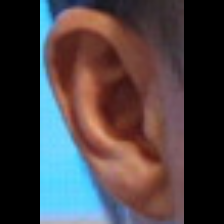

In [ ]:
from keras.preprocessing.image import array_to_img
array_to_img(image_dataset_awe[34])

In [ ]:
image_dataset = image_dataset_awe
labels = labels_awe

image_dataset_awe = []
labels_awe = []

In [ ]:
import imgaug.augmenters as iaa
import imgaug as ia

class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False, n_aug=1):
    self.labels       = labels              # array of labels
    self.images       = images              # array of images
    self.dim          = image_dimensions    # image dimensions
    self.batch_size   = batch_size          # batch size
    self.shuffle      = shuffle             # shuffle bool
    self.augment      = augment             # augment data bool

    if(not self.augment):
      n_aug = 0
    self.n_aug        = n_aug

    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(self.images.shape[0] / self.batch_size)) * (1+self.n_aug)

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange( self.images.shape[0] )
    self.indexes = np.repeat(self.indexes, 1+self.n_aug)
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index):
    'Generate one batch of data'
    # selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

    # select data and load images
    labels = self.labels[indexes]
    images = self.images[indexes]
        
    # preprocess and augment data
    if self.augment == True:
      images = self.augmentor(images)
    
    return images, labels


  def augmentor(self, images):
    'Apply data augmentation'
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    
    seq = iaa.Sequential(
        [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        sometimes(iaa.Affine(
          scale=(0.8, 1.2),
          # scale images to 80-120% of their size, individually per axis
          rotate=(-45, 45),  # rotate by -45 to +45 degrees
        )),
        # execute 0 to max of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        sometimes(
          iaa.SomeOf((2, None),
                      [
                      iaa.OneOf([
                            iaa.GaussianBlur((0, 2.0)),
                            # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(3, 5)),
                            # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 5)),
                            # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        #iaa.Sharpen(alpha=(0, 1.0), lightness=(0.8, 1.2)),
                        # sharpen images
                        iaa.AdditiveGaussianNoise(loc=0,
                                                  scale=(0.0, 0.2), per_channel=0.5),
                        # add gaussian noise to images
                        iaa.LinearContrast((0.75, 1.5), per_channel=0.1),
                        iaa.Multiply((0.8, 1.2)),
                        #iaa.AddToBrightness((-10, 10)),
                        iaa.Crop(percent=(0, [0, 0.1], 0, [0, 0.1]))
                      ],
                      random_order=True
          )
        ),
      ],
      random_order=True)
    return seq.augment_images(images)

In [ ]:
import time
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback

In [ ]:
class MobileModel():
  def __init__(self, image_dimensions=(224,224 ,3), n_classes=100):
    self.n_classes = n_classes  # number of classes to classify
    self.input_dim = image_dimensions  # image input dimensions
    self.model = self.create_model()  # model

  def summary(self):
    self.model.summary()

  def create_model(self):
    self.base_model = keras.applications.MobileNetV3Large(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3),
        include_top=False,
        pooling='avg')
    
    self.base_model.trainable = False

    inputs = keras.Input(shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3))

    #x = data_augmentation(inputs)
    x = keras.applications.mobilenet_v3.preprocess_input(inputs)
    x = self.base_model(x, training=False)

    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    x = keras.layers.Dense(128, activation='relu')(x)

    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
    x = keras.layers.Dense(100, activation='relu')(x)
    outputs = keras.layers.Dense(100, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    return model


  def train(self, train_data, val_data, plot_results=True, epochs=10):
    'Trains classifier part of the model with data from generators'
    print("Starting training")

    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                                patience=2,
                                                verbose=1,
                                                factor=0.5,
                                                min_lr=0.000001)

    # stop training if no improvements are seen
    early_stop = EarlyStopping(monitor="loss",
                              mode="min",
                              patience=5,
                              restore_best_weights=True)

    # saves model weights to file
    checkpoint = ModelCheckpoint('/content/models//model_weights.hdf5',
                                monitor='loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min',
                                save_weights_only=True)

    # visualize training data
    # tensorboard = TensorBoard(log_dir='./logs',
    #                          histogram_freq=0,
    #                          batch_size=BATCH_SIZE,
    #                          write_graph=True,
    #                          write_grads=True,
    #                          write_images=False)

    # reduce resource usage(keeps laptop from melting)
    # idle = LambdaCallback(on_epoch_end=lambda batch, logs: time.sleep(30),
    #                      on_batch_end=lambda batch, logs: time.sleep(0.005))

    # train on data
    self.model.compile(optimizer=keras.optimizers.Adam(0.02),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    history = self.model.fit(
                  train_data,
                  validation_data=val_data,
                  epochs=epochs,
                  validation_steps=len(val_data),
                  steps_per_epoch=len(train_data),
                  callbacks=[learning_rate_reduction, early_stop, checkpoint],
                  verbose=2,
                  )
    # plot training history
    if plot_results:
      fig, ax = plt.subplots(2, 1, figsize=(6, 6))
      ax[0].plot(history.history['loss'], label="TrainLoss")
      ax[0].plot(history.history['val_loss'], label="ValLoss")
      ax[0].legend(loc='best', shadow=True)

      ax[1].plot(history.history['accuracy'], label="TrainAcc")
      ax[1].plot(history.history['val_accuracy'], label="ValAcc")
      ax[1].legend(loc='best', shadow=True)

      plt.show()

  def finetune(self, finetune_data, val_data, plot_results=True, epochs=10):
    'Finetunes whole model with data from generators'
    print("Starting finetuning")

    # reduces learning rate if no improvement are seen
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss',
                                                patience=2,
                                                verbose=1,
                                                factor=0.2,
                                                min_lr=1e-7)

    # stop training if no improvements are seen
    early_stop = EarlyStopping(monitor="loss",
                              mode="min",
                              patience=5,
                              restore_best_weights=True)

    # saves model weights to file
    checkpoint = ModelCheckpoint('/content/models//finetuned_model_weights.hdf5',
                                monitor='loss',
                                verbose=1,
                                save_best_only=True,
                                mode='min',
                                save_weights_only=True)

    self.base_model.trainable = True
    self.model.summary()

    self.model.compile(optimizer=keras.optimizers.Adam(5e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
    
    history = self.model.fit(
                  finetune_data,
                  validation_data=val_data,
                  epochs=epochs,
                  validation_steps=len(val_data),
                  steps_per_epoch=len(finetune_data),
                  callbacks=[learning_rate_reduction, early_stop, checkpoint],
                  verbose=2,
                  )
    
    # plot training history
    if plot_results:
      fig, ax = plt.subplots(2, 1, figsize=(6, 6))
      ax[0].plot(history.history['loss'], label="TrainLoss")
      ax[0].plot(history.history['val_loss'], label="ValLoss")
      ax[0].legend(loc='best', shadow=True)

      ax[1].plot(history.history['accuracy'], label="TrainAcc")
      ax[1].plot(history.history['val_accuracy'], label="ValAcc")
      ax[1].legend(loc='best', shadow=True)

      plt.show()

  def load_weights_from_checkpoint(self):
    self.model.load_weights('/content/models/model_weights.hdf5')
  
  def evaluate(self, X_test, y_test):
    scores = self.model.evaluate(X_test, y_test)
    print('Loss: %.3f' % scores[0])
    print('accuracy: %.3f' % scores[1])

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(image_dataset, to_categorical(labels), test_size=0.1)
X_train, X_finetune, y_train, y_finetune = model_selection.train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
X_train.shape, X_finetune.shape, X_test.shape

((720, 224, 224, 3), (180, 224, 224, 3), (100, 224, 224, 3))

In [ ]:
train_data = DataGenerator(X_train, y_train, batch_size=BATCH_SIZE, augment=True, n_aug=15, shuffle=True)
val_data = DataGenerator(X_test, y_test, batch_size=BATCH_SIZE, augment=False, shuffle=False)

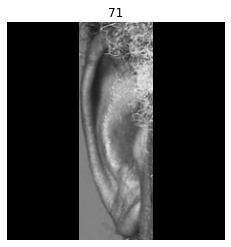

In [ ]:
data = train_data[1]
for im, label in zip(data[0], data[1]):
  plt.imshow(im.astype('uint8'))
  plt.title(label.argmax())
  plt.axis("off")

In [ ]:
model = MobileModel()
model.summary()

17620992/17605208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1280)             4226432   
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                              

Starting training
Epoch 1/300

Epoch 00001: loss improved from inf to 3.88413, saving model to /content/models/model_weights.hdf5
176/176 - 67s - loss: 3.8841 - accuracy: 0.1336 - val_loss: 4.1175 - val_accuracy: 0.0781 - lr: 0.0200 - 67s/epoch - 383ms/step
Epoch 2/300

Epoch 00002: loss improved from 3.88413 to 2.92759, saving model to /content/models/model_weights.hdf5
176/176 - 54s - loss: 2.9276 - accuracy: 0.2694 - val_loss: 4.4353 - val_accuracy: 0.1094 - lr: 0.0200 - 54s/epoch - 306ms/step
Epoch 3/300

Epoch 00003: loss improved from 2.92759 to 2.55815, saving model to /content/models/model_weights.hdf5
176/176 - 53s - loss: 2.5581 - accuracy: 0.3498 - val_loss: 4.3248 - val_accuracy: 0.1719 - lr: 0.0200 - 53s/epoch - 301ms/step
Epoch 4/300

Epoch 00004: loss improved from 2.55815 to 2.35078, saving model to /content/models/model_weights.hdf5
176/176 - 53s - loss: 2.3508 - accuracy: 0.3862 - val_loss: 4.7030 - val_accuracy: 0.1562 - lr: 0.0200 - 53s/epoch - 299ms/step
Epoch 5/30

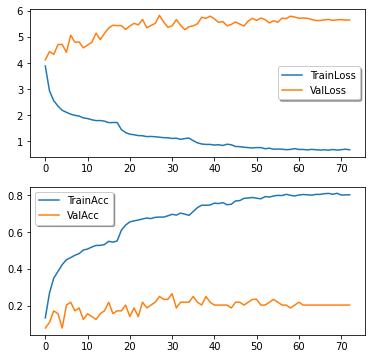

In [ ]:
# train model
model.train(train_data, val_data, plot_results=True, epochs=300)

In [ ]:
# Evaluate the model
scores = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 147ms/step - loss: 5.7761 - accuracy: 0.2000
Loss: 5.776
accuracy: 0.200


In [ ]:
finetune_data = DataGenerator(X_finetune, y_finetune, batch_size=BATCH_SIZE, augment=True, n_aug=50, shuffle=True)

In [ ]:
finetuned_model = MobileModel()

Starting finetuning
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1280)             4226432   
 l)                                                              
                                                                 
 batch_normalization_6 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_7 (Batc  (None, 12

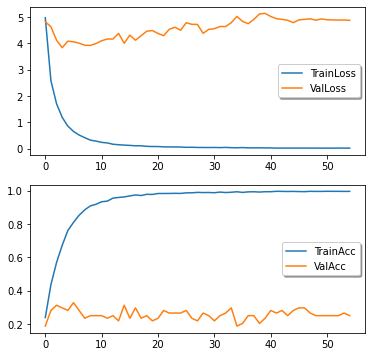

In [ ]:
finetuned_model.load_weights_from_checkpoint()
finetuned_model.finetune(finetune_data, val_data, epochs=150)

In [ ]:
# Evaluate the model
scores = finetuned_model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 32ms/step - loss: 4.9286 - accuracy: 0.2600
Loss: 4.929
accuracy: 0.260


In [ ]:
#model.save("/content/models/earRecognition", save_format="h5")

In [ ]:
!tar -czvf model.tar.gz /content/models/

tar: Removing leading `/' from member names
/content/models/
/content/models/model_weights.hdf5
/content/models/finetuned_model_weights.hdf5


In [ ]:
from google.colab import files
files.download('model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>